In [62]:
import warnings
warnings.filterwarnings('ignore')
import torch
from torch import nn
import pandas as pd
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer

In [63]:
MODEL_NAME='vinai/phobert-base-v2'

In [64]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 40

In [65]:
class_names=['negative','neutral','positive']
# Set GPU
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device = torch.device(device)

In [66]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.phobert = AutoModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(self.phobert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.phobert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.linear(pooled_output)
        return logits

In [67]:
model = SentimentClassifier(3)
model.load_state_dict(torch.load('Model/train_3.bin'))
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SentimentClassifier(
  (phobert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [68]:
def encode_predict(comment_test):
    encoded_review = tokenizer.encode_plus(
        comment_test,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    # print(f'{comment_test}',':', f'{class_names[prediction]}')
    
    return class_names[prediction]


In [9]:
# df=pd.read_csv('Data/Cleaned.csv')
# data1=df[160000:]
# data1

,user,Comment,comment_at
160000,TUẤN NHUNG,quá cho folow,NaN
160001,Trần Thị Thúy,chưa chín dở,NaN
160002,hhadrenty,vãi lồn đói bụng,NaN
160003,Su HL 1199,this coment reminds everyone to drink water re...,NaN
160004,Nguyễn Hữu Đạt,ai vào nick vy mà ra được mai có người_yêu,NaN
...,...,...,...
160554,vecto là một đthang có hướng😇,e thích ăn_chay lắm mẹ em làm ngon lắm ý cj cj...,NaN
160555,Chồng đáng yêu của bé DaKi🦊,mình nghĩ thực_vật cũng góp_phần tạo nên bầu_k...,NaN
160556,N.Duy Đức,mình đã ăn_chay tháng công_nhận đa_dạng và ngon,NaN
160557,Cơ điện Vũ Thức,trông như thật,NaN


In [10]:
# data1['Label'] = data1['Comment'].apply(encode_predict)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [11]:
# data1.head(10)

,user,Comment,comment_at,Label
160000,TUẤN NHUNG,quá cho folow,NaN,neutral
160001,Trần Thị Thúy,chưa chín dở,NaN,negative
160002,hhadrenty,vãi lồn đói bụng,NaN,negative
160003,Su HL 1199,this coment reminds everyone to drink water re...,NaN,neutral
160004,Nguyễn Hữu Đạt,ai vào nick vy mà ra được mai có người_yêu,NaN,neutral
160005,Bùi Duyên,woa thấy anh kiếm được lá dong ở mĩ là đỉnh rồi,NaN,neutral
160006,Nguyễn Huy Hoàng,htps,NaN,neutral
160007,nói phét đấy!Tin đi-)))),như này phải,NaN,neutral
160008,Trung anh,nuốt nửa lít nước_bọt luôn ban,NaN,neutral
160009,💥 Thanh Tài ⚡️,mở miệng ra mà ông ăn thì bằng không,NaN,neutral


<AxesSubplot: >

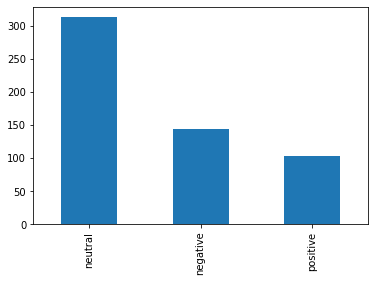

In [12]:
# #vẽ biểu đồ với cột Label
# data1['Label'].value_counts().plot(kind='bar')

In [13]:
# data1['Label'].value_counts()

neutral     313
negative    143
positive    103
Name: Label, dtype: int64

In [69]:
def encode_predict_(comment_test):
    encoded_review = tokenizer.encode_plus(
        comment_test,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    # print(f'{comment_test}',':', f'{class_names[prediction]}')
    
    return prediction


In [93]:
df_1=pd.read_csv('Data/1000.csv')
df_1['Label'] = df_1['Label'].apply(lambda x: x+1)

In [94]:
df_1=df_1.dropna()

<AxesSubplot: >

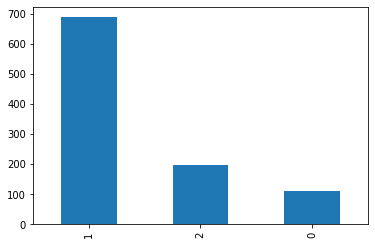

In [95]:
df_1['Label'].value_counts().plot(kind='bar')

In [96]:
df_1['Predict'] = df_1['Comment'].apply(encode_predict_).apply(lambda x: x.item() if hasattr(x, 'item') else x)


In [97]:
count = 0
sum = 0
for i in range(len(df_1)):
    try:
        sum += 1
        if df_1['Label'][i] == df_1['Predict'][i]:
            count += 1
    except:
        pass
accuracy = count/sum
print(accuracy)


0.6934673366834171


In [98]:
df_1

,user,Comment,Label,Predict
0,Ínnn sắp gầy🥕,tam_mỹ nguyễn_toker nè,1,1
1,MingMing,địa_chỉ trung_hòa là bn vậy em,1,1
2,Hoa Hải đường,ở đâu vậy cả nhà,1,1
3,Vi Vu Cùng VeeA ✨,hcm có chỗ nào không ạ,1,1
4,Nhi Kẹo,linh ngon ghê,2,2
...,...,...,...,...
996,Thuỷ tiên🎀,team chỉ ăn đk gà ta gà thả,1,0
997,Lương Hoàng 🌷,đứa làm ở trại gà trắng nhìn thấy con gà này kiểu,1,1
998,Tùng đầu bạc,chắc_ăn ngon lắm,2,2
999,Minh Đức,gà công_nghiệp đâu ra con,1,1


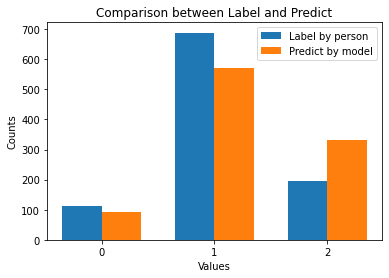

In [99]:

label_counts = df_1['Label'].value_counts().sort_index()
predict_counts = df_1['Predict'].value_counts().sort_index()

width = 0.35
fig, ax = plt.subplots()
bar_label = ax.bar(label_counts.index - width/2, label_counts.values, width, label='Label by person')
bar_predict = ax.bar(predict_counts.index + width/2, predict_counts.values, width, label='Predict by model')

ax.set_xlabel('Values')
ax.set_ylabel('Counts')
ax.set_title('Comparison between Label and Predict')
ax.set_xticks(range(len(label_counts.index)))
ax.set_xticklabels(label_counts.index)
ax.legend()
plt.show()

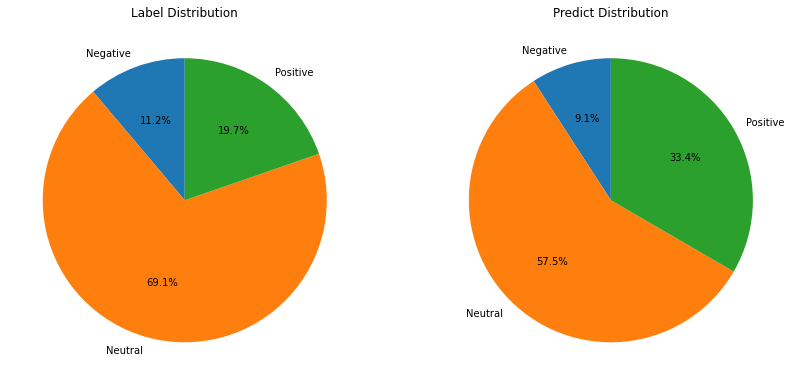

In [100]:
label_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
df_1['Label'] = df_1['Label'].replace(label_mapping)
df_1['Predict'] = df_1['Predict'].replace(label_mapping)

# Đếm số lần xuất hiện của từng giá trị sau khi thay đổi nhãn
label_counts = df_1['Label'].value_counts().sort_index()
predict_counts = df_1['Predict'].value_counts().sort_index()
plt.figure(figsize=(14, 8))
# Tạo biểu đồ tròn cho 'label'
plt.subplot(1, 2, 1)
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Label Distribution')

# Tạo biểu đồ tròn cho 'predict'
plt.subplot(1, 2, 2)
plt.pie(predict_counts, labels=predict_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Predict Distribution')

# Hiển thị biểu đồ
plt.show()